- [Generative Adversarial Networks](https://arxiv.org/abs/1406.2661)
- [NIPS 2016 Tutorial:
Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
- [image source](https://xiaohongliu.ca/post/gan/)

## Library

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import numpy as np
import math
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader

In [3]:
torch.__version__    

'1.13.1+cu117'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.manual_seed(2023)

## Hyperparameters

In [6]:
"""
학습에 사용될 hyperparameter 값들을 넣을 class를 정의합니다.
"""
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [7]:
"""
GAN model 학습에 사용되는 결과 이미지 저장 경로, 에포크 수, 모델 입력 이미지 크기 등을 정의합니다.
"""
config = AttrDict()
config.data_path = 'data/resource_2/' 
config.save_path = 'save/DCGAN_64/'
#config.dataset = 'CIFAR10' #CIFAR10 어떠한 데이터셋을 사용하는지
config.dataset = 'emoji'

config.n_epoch = 200
config.log_interval = 150 # loss 출력
config.save_interval = 3  # 이미지 출력
config.batch_size = 200

config.nz = 100
config.ngf = 128 # generator oonv filter
config.ndf = 128 # discriminator oonv fillter

config.learning_rate = 0.00001
config.b1 = 0.5
config.b2 = 0.999
config.img_shape = (3, 64, 64) # c, w, h
config.latent_size = 100 # random noise size
"""
모델 입력 이미지에 수행할 normalization과 모델 생성 결과 이미지에 수행할 denormalization을 정의합니다.
"""
config.augmentation = transforms.Compose([
                        transforms.Resize((config.img_shape[1], config.img_shape[2])), #resize
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.5], std=[0.5]) #normalization
                      ])
config.denormalize = lambda x: x*0.5+0.5 #denormalization 위의 단계 reverse , 원래의 이미지를 보기 위해 수행함

config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #cuda에 올리기

In [8]:
#지정된 경로의 데이터셋 가져오기 및 저장
if not os.path.isdir(config.data_path):
    os.makedirs(config.data_path)
if not os.path.isdir(os.path.join(config.save_path, config.dataset)):
    os.makedirs(os.path.join(config.save_path, config.dataset))

In [9]:
config.device

device(type='cuda')

## Data load

In [10]:
"""
MNIST와 CIFAR-10은 torchvision 라이브러리에서 제공하여 아래와 같이 사용할 수 있습니다.
"""
                                 
if config.dataset == 'CIFAR10': 
    train_dataset = datasets.CIFAR10(config.data_path,
                                       train=True,
                                       download=True,
                                       transform=config.augmentation
                                     )
elif config.dataset == 'emoji': 
    train_dataset = datasets.ImageFolder(config.data_path,
                                         transform=config.augmentation
                                     )

print(config.dataset)
    
"""
training set을 Dataloader에 넣습니다. 
"""
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers = 2)
print(train_dataset)

emoji
Dataset ImageFolder
    Number of datapoints: 6000
    Root location: data/resource_2/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [11]:
len(train_dataset)

6000

In [12]:
img, label = train_dataset[0]

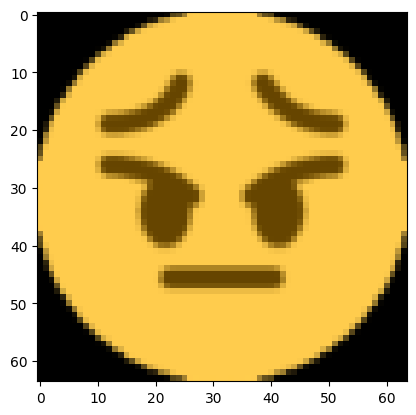

In [13]:
plt.imshow(to_pil_image(0.5*img+0.5))

## custom data

로컬 디렉토리 image 가져오기

In [14]:
import urllib.request
import zipfile
import glob

In [15]:
data_path = ''
glob.glob('data/resource/emoji/*')[:20]

[]

In [16]:
train_loader

## GAN model

In [17]:
config.img_shape

(3, 64, 64)

In [18]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

"""
 일반적으로, GAN에서는 loss가 Discriminator에서부터 Generator로 흐를 때 생길 수 있는 
 vanishing gradient 현상을 완화하기 위해 Leaky ReLU를 많이 사용합니다. 
"""
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

class Generator(nn.Module): # 입력으로 noise를 받음
    def __init__(self, config):
        super().__init__()
    
        n_ditsributions = 3
        
        mu = 2 * torch.rand(n_ditsributions) - 1
        mu.requires_grad = True
        
        self.mu = nn.Parameter(mu)
        
        sigma = 1.0 * torch.ones(n_ditsributions)
        sigma.requires_grad = True
        
        self.sigma = nn.Parameter(sigma)
        
        self.dconv1 = nn.ConvTranspose2d(config.latent_size, config.ngf*8, 4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(config.ngf*8)
        #62
            
        self.dconv2 = nn.ConvTranspose2d(config.ngf*8, config.ngf*4, 4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(config.ngf*4)
        #15   
            
        self.dconv3 = nn.ConvTranspose2d(config.ngf*4, config.ngf*2, 4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(config.ngf*2)
            
        self.dconv4 = nn.ConvTranspose2d(config.ngf*2, config.ngf,4,stride=2,padding=1)
        self.bn4 = nn.BatchNorm2d(config.ngf)
            
        self.dconv5 = nn.ConvTranspose2d(config.ngf, config.img_shape[0], 4,stride=2, padding=1)
        
    def forward(self, z):
        #for i in range(3):
        z1 = z  + self.mu[0]

        
        
        
        #z = (z-torch.mean(z))/(torch.std(z))
        
        b = z.view(200, 100)
        a = b[0].cpu().detach().numpy()
        sns.histplot(a, kde=True)
        plt.show()
        
        #print('self.mu',self.mu)
        #print('self.sigma',self.sigma)
        #idx = torch.randint(0, self.mu.size(0), input.size())
        #input = input * self.sigma[idx] + self.mu[idx]
        #print(z)
        #print(z.shape)
        #print(z)
        #x = z.view(-1, 100, 1, 1)
        #print(z.shape)
        
        x = F.leaky_relu(self.bn1(self.dconv1(z)), 0.2)
        x = F.leaky_relu(self.bn2(self.dconv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.dconv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.dconv4(x)), 0.2)
        x = torch.tanh(self.dconv5(x))
        #img = img.reshape(img.shape[0], *config.img_shape)
        return x

In [19]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv1 = nn.Conv2d(config.img_shape[0],config.ndf,4,stride=2,padding=1,bias=False)
        self.conv2 = nn.Conv2d(config.ndf,config.ndf*2,4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(config.ndf*2)
        
        self.conv3 = nn.Conv2d(config.ndf*2, config.ndf*4,4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(config.ndf*4)
        
        self.conv4 = nn.Conv2d(config.ndf*4,config.ndf*8,4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(config.ndf*8)
        
        self.conv5 = nn.Conv2d(config.ndf*8,1,4,stride=1,padding=0,bias=False)

    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)),0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)),0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)),0.2)
        x = torch.sigmoid(self.conv5(x))
        return x.view(-1,1)

#### Binary Cross Entropy loss between the target and the input probabilities

- [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)

In [20]:
"""
binary cross entropy loss를 사용하여 adversarial loss를 구현합니다.
"""
criterion = nn. BCELoss()

"""
Generator와 Discriminator를 각각 정의하고, 상응하는 optimizer도 함께 정의합니다.
"""
generator = Generator(config).to(config.device)
discriminator = Discriminator(config).to(config.device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=config.learning_rate, betas=(config.b1, config.b2))

## Training

In [ ]:
import numpy as np
#from torchmetrics.image.fid import FrechetInceptionDistance
#from torchmetrics.image.inception import InceptionScore
#import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#inception = InceptionScore()
"""
Generator와 Discriminator를 번갈아 학습합니다.
"""
g_loss_list = []
d_loss_list = []
for epoch in tqdm(range(config.n_epoch)):
    for i, (real_img, _) in enumerate(train_loader):
        real_img = real_img.to(config.device)

        """
        adversarial loss에 사용될 ground truth들입니다.
        Discriminator에게 있어 실제 이미지는 1, generator가 생성한 fake 이미지는 0을 label로 합니다.
        반대로 Generator는 자신이 생성한 fake 이미지의 label이 1이 되게 하여 Discriminator를 fooling 합니다.
        """
        
        valid_label = torch.ones((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        #print(valid_label)
        #print(valid_label.shape)
        fake_label = torch.zeros((real_img.shape[0], 1), device=config.device, dtype=torch.float32)
        
        # ====================================================#
        #                Train Discriminator                  #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        # 가짜 이미지 생성
        #rint(real_img.shape[0])
        
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        #print(real_img.shape)
        #print(real_img.shape[0])
        #print(z.shape)
        gen_img = generator(z)
        

        """
        Discriminator가 실제 이미지와 Generator가 생성한 이미지를 잘 구별하는지 loss를 계산합니다.
        이 때, Generator는 현재 계산된 loss로 학습되지 않으므로, 
        detach() 함수를 이용하여 생성 이미지를 computation graph에서 분리한 후 Discriminator의 입력으로 넣어줍니다. 
        """
        #print(discriminator(real_img))
        #print(discriminator(real_img).shape)
        ## loss 구함
        real_loss = criterion(discriminator(real_img), valid_label)
        fake_loss = criterion(discriminator(gen_img.detach()), fake_label) # detach generator는 가중치 업데이트 안함
        d_loss = (real_loss + fake_loss) * 0.5
        
        
        
        """
        Discriminator를 업데이트합니다.
        """
        optimizer_d.zero_grad()
        d_loss.backward() # 여기서 grediant가 업데이트 안됨
        optimizer_d.step()

        
        # ====================================================#
        #                   Train Generator                   #
        # ====================================================#

        """
        Gaussian random noise를 Generator에게 입력하여 fake 이미지들을 생성합니다.
        """
        z = torch.randn((real_img.shape[0], config.latent_size), device=config.device, dtype=torch.float32)
        gen_img = generator(z)  

        """
        Generator가 Discriminator를 속일 수 있는지 loss를 계산합니다.
        """
        g_loss = criterion(discriminator(gen_img), valid_label) #valid_label로 하여 generator를 학습하게 함
        
 
        
        """
        Generator를 업데이트합니다.
        """
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
        
#         if (epoch+1) % config.save_interval == 0:
#                 fid = FrechetInceptionDistance(feature=64)
#                 real = torch.tensor(real_img,dtype=torch.uint8).cpu()
#                 fake = torch.tensor(gen_img,dtype=torch.uint8).cpu()
        
#                 fid.update(real, real=True)
#                 fid.update(fake, real=False)
                
#                 inception.update(fake)
        
#                 if i == 0:
#                     is_s1,is_s2  = inception.compute()
#                     fid_s = fid.compute()
#                 else:
#                     is_s1,is_s2 = inception.compute()
#                     is_s1 += is_s1
#                     is_s2 += is_s2
                    
#                     fid_s +=fid.compute()
                    
                    
#                 if (i+1) % config.log_interval == 0: 
#                     print('Epoch [{}/{}] Batch [{}/{}] Discriminator fid: {} is1:{} is2:{}'.format(
#                     epoch+1,
#                     config.n_epoch,
#                     i+1,
#                     len(train_loader),
#                     fid_s/(i+1),
#                     is_s1/(i+1),
#                     is_s2/(i+1)
#                     ))
  
        if (i+1) % config.log_interval == 0:
            g_loss_list.append(g_loss.item())
            d_loss_list.append(d_loss.item())
            print('Epoch [{}/{}] Batch [{}/{}] Discriminator loss: {:.4f} Generator loss: {:.4f}'.format(
                epoch+1,
                config.n_epoch,
                i+1,
                len(train_loader),
                d_loss.item(),
                g_loss.item()
            ))
                
            
    if (epoch+1) % config.save_interval == 0:
        save_path = os.path.join(config.save_path, config.dataset, 'epoch_[{0:-03d}]_fid[].png'.format(
            epoch+1,
            #fid_s/(i+1)
        ))
        gen_img = config.denormalize(gen_img)
        torchvision.utils.save_image(gen_img.data[:16], save_path, nrow=4, normalize=True)

In [21]:
# z = torch.randn((5, 100), device=config.device, dtype=torch.float32)

# z, torch.min(z),torch.min(z[0])

In [ ]:
plt.title('GAN training loss on {} data'.format(config.dataset))
plt.plot(g_loss_list, label='generator loss')
plt.plot(d_loss_list, label='discriminator loss')
plt.legend()
plt.show()

## Qualitative results

In [ ]:
save_path = os.path.join(config.save_path, config.dataset)
for image_path in os.listdir(save_path):
    if image_path.endswith('.png'):
        plt.figure(figsize=(5,5))
        image = Image.open(os.path.join(save_path, image_path))
        plt.title(image_path)
        plt.imshow(image)
        plt.show()

# 